# Chapter 7 - Eligibility Traces

This chapter starts by introducing n-step TD methods, which sit between the two extremes: TD(0), or 1-step TD and Monte-Carlo (which can be considered an $\infty$-step TD). Then it builds on that to consider n-step backups and n-step returns, and mixing multiple n-step returns into a complex backup, which is the TD($\lambda$) algorithm.

It then looks at the TD($\lambda$) family of algorithms from two perspectives - forward and backward view, by using forward for a better conceptual understanding, while the backward view is more appropriate for the actual implementation.

And finally we are introduced to variants of known algorithms that use the TD($\lambda$) updates, like Sarsa($\lambda$), Q($\lambda$) and Eligibility Traces for actor-critic methods.

### Exercise 7.1

Why do you think a larger random walk task (19 states instead of 5) was used in the examples of this chapter? Would a smaller walk have shifted the advantage to a different value of $n$? How about the change in left-side outcome from $0$ to $-1$? Would that have made any difference in the best value of $n$?

A random walk over a small number of states should see not much difference between using 1-step TD updates or using every-visit MC, because the probability of reaching a terminal state from any given state is relatively high, e.g. between $\frac{1}{2}$ and $\frac{1}{8}$ for the 5 states task. That means that a small proportion of epsisodes would actually use a full n-step backup for the updates, i.e. after some (small) optimal length $n^*$, the value of longer $n$ would bring no benefit. Therefore a random walk task with 19 states gives more "opportunity" to show how different outcomes can be for different $n$'s, and how the optimum is somewhere in the middle between 1-step TD and MC.

For a similar reason, the change of the left terminal reward to $-1$ provides a more "dramatic" curve between multiple values of $n$; intuitively I expect the curves would have been flatter if the left terminal reward remained $0$, especially over only 10 episodes to learn from.

### Exercise 7.2

Why do you think on-line methods worked better than off-line methods on the example taks?

I expect the off-line methods have a slower start on most tasks, because they only update once per episode. In this case the results presented and the graphs in Figure 7.2 used only the first 10 episodes, which can be considered little for a task with 19 states! However, it must be mentioned that the advantage of off-line methods is that the update is usually more stable, being an average over potentially multiple passes through a state per episode and on the longer term converge to the same optimum as the on-line methods.

### Exercise 7.3

Explain why the plots for off-line n-step TD show a worse performance for $n=3, 5, 7, 9$ at a much lower value of $\alpha$ than for $n=2, 4, 6, etc.$ (Figure 7.2)

First read the [Other Notes on the Errata page](http://incompleteideas.net/book/first/errata.html). <br>

Initially my intuition went something like this. In this task all rewards are $0$ except for the terminal transitions. So for all n-step returns starting from some $s_{start}$, the off-line update only depends on the values of all the end state(s) reached after $n$ jumps (or less if a terminal state is reached). Let's call them $s_{end}$.

The first observation is that by starting from any fixed position $s_{start}$ and making n-step jumps, __if $n$ is odd, the end positions will always have the opposite parity of the starting position__ (excepting terminal states when the walk is cut short). For example from state $7$, all possible 3-step jumps finish in either $4$, $6$, $8$ or $10$. But __if $n$ is even, the end state always has the same parity as the starting state__ (including itself). For instance from $7$ all possible 4-step jumps finish in either $3$, $5$, $7$, $9$ or $11$.

The second observation, according to __the formula on page 166 for off-line updates__, says that all increments are accumulated "on the side" during the episode and applied at the end. Notice that in our case each increment at time $t$ is something like this, since $\gamma=1$ and all intermediary rewards are $0$ as discussed above: 

$$
\Delta V_t(s_{start}) = \alpha \left[ R_t^{(n)} - V_t(s_{start}) \right] = \alpha \left[ V_t(s_{end}) - V_t(s_{start}) \right], \\
\text {if } s_t = s_{start} \text { and } 0 \text { otherwise}.
$$

The off-line update thus becomes, for each $s_{start}$ visited during the episode:

$$
V(s_{start}) \leftarrow V(s_{start}) + \alpha \sum_{t=0}^{T-1} \Delta V_t(s_{start}) = V(s_{start}) + \alpha \sum_{s_{end}} \left[ V(s_{end}) - V(s_{start}) \right]
$$


From these two observations we derive two consequences:

 - __If $n$ is odd__, after every off-line update as per the formula above, the values of $V(odd\_positions)$ will be updated towards some function of $V(even\_positions)$ and vice-versa. Which can create a self-reinforcing error propagation from one update to the next over multiple episodes, especially for the positions far from the two terminal states. This effect is magnified by a large $\alpha$.
 
 - __If $n$ is even__, a significant proportion of n-step walks will finish in the starting position, thus reducing the update value, because the n-step TD error will be zero for those cases (as per the formula). It could be considered equivalent to using a smaller $\alpha$ overall. Also, $V(odd\_positions)$ will always be updated only from other $V(odd\_positions)$ and similarly for even positions. This kind of "segregation of states" means that if there is a large over/under-estimate somewhere, it will get propagated to at most half of the states around it, not to all.

For these two reasons we could expect a worse performance from odd $n$'s, especially for larger values of $\alpha$ and small number of episodes.

__But this explanation doesn't account for something much more curious and obvious, in retrospect. If you look closely at both graphs in Figure 7.2, the x-axis are very different!__ For the on-line update, $\alpha$ sweeps from $0$ to $1$, while in the off-line update it stops at $0.3$. As we'll see in the plots below, if $\alpha$ was made larger than $0.3$, the off-line RMS error shoots up to huge numbers, for both odd and even $n$'s. So let's implement a quick off-line n-step TD algorithm, over 100 experiments of 10 random walks starting from the middle, i.e. the same settings as in the book.

In [112]:
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Implementing the 19 states random walk task
# rewards are -1 and 1 for transitions to the left 
# and right terminals and 0 everywhere else.
def generate_walk(nb_states=19):
    s = nb_states // 2 + 1  # start from the center state
    walk = [s]
    while s > 0 and s <= nb_states:
        move = random.choice([-1, 1])
        s += move
        walk.append(s)
    return walk

# Create a batch of 100 experiments
# of 10 random walks each.
experiments = []
for e in range(100):
    # Generate 10 different walks
    walks = []
    for _ in range(10):
        walks.append(generate_walk(nb_states=19))
    experiments.append(walks)

In [108]:
# Implement the off-line n-step TD update
# from a list of walks
def off_line_n_step_update(walks, n, alpha, nb_states=19):
    # init V=0, plus -1, 1 on the sides
    V = [-1.] + [0.] * nb_states + [1.]
    for walk in walks:
        # DeltaV to be used for the update at the end of the episode
        DV = {}
        DV_k = {}  # counter

        for pos in range(len(walk)-1):
            start_state = walk[pos]
            end_state = walk[min(pos + n, len(walk)-1)]

            if start_state not in DV:
                DV[start_state] = 0.
                DV_k[start_state] = 0
            # accumulate DeltaV "on the side"
            DV[start_state] += V[end_state] - V[start_state]
            DV_k[start_state] += 1

        new_V = V.copy()
        # update V for all visited states
        for s in range(1, nb_states+1):
            if s in DV:
                # original formula page 166
                new_V[s] = new_V[s] + alpha * DV[s]
        V = new_V
    return V

In [72]:
# The true value of each state in the 19 states random walk
true_V = [(k-10.)/10. for k in range(21)]

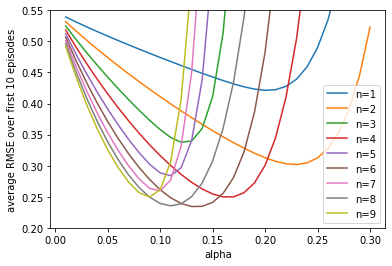

In [115]:
# Reproduce Figure 7.2, off-line update
alpha_list = [a/100. for a in range(1, 31)] # just from 0.01 to 0.3
for n in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    rmse = []
    for alpha in alpha_list:
        tmp_rmse = 0.
        for e in range(100):
            walks = experiments[e]  # the set of 10 walks
            V = off_line_n_step_update(walks, n=n, alpha=alpha)
            tmp_rmse += math.sqrt(sum([(vi - true_vi)**2 for vi, true_vi in zip(V, true_V)]) / (len(V) - 2)) # exclude terminal states
        rmse.append(tmp_rmse / 100.)  # average over the 100 experiments
    plt.plot(alpha_list, rmse, label=f'n={n}')
plt.xlabel('alpha')
plt.ylabel('average RMSE over first 10 episodes')
plt.ylim(bottom=0.2, top=0.55)
plt.legend()
plt.show()

It's visible how the RMS errors get clustered and shooting up for $n=3, 5, 7, 9$ around $\alpha=0.15$, much earlier than for $n=1, 2, 4, 6, 8$. This confirms the behaviour described in Exercise 7.3.
But see how they tend to shoot out of the plot almost vertically. What if we don't cut it at RMSE = 0.55?

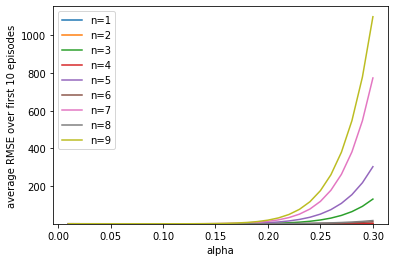

In [116]:
# Reproduce Figure 7.2, off-line update, but no upward limit
alpha_list = [a/100. for a in range(1, 31)] # just from 0.01 to 0.3
for n in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    rmse = []
    for alpha in alpha_list:
        tmp_rmse = 0.
        for e in range(100):
            walks = experiments[e]  # the set of 10 walks
            V = off_line_n_step_update(walks, n=n, alpha=alpha)
            tmp_rmse += math.sqrt(sum([(vi - true_vi)**2 for vi, true_vi in zip(V, true_V)]) / (len(V) - 2)) # exclude terminal states
        rmse.append(tmp_rmse / 100.)  # average over the 100 experiments
    plt.plot(alpha_list, rmse, label=f'n={n}')
plt.xlabel('alpha')
plt.ylabel('average RMSE over first 10 episodes')
plt.ylim(bottom=0.2)
plt.legend()
plt.show()

Ok, so the RMS errors get huge for odd $n$'s when $\alpha$ approaches $0.3$. How can this be? 

Even if the estimates were really wrong, for instance the extremes of $1$ vs. $-1$, one wouldn't expect RMSE to go beyond $\sqrt{(1-(-1))^2} = 2$. So what is going on?

What if we plot only the RMSE for even $n$'s; are they behaving better?

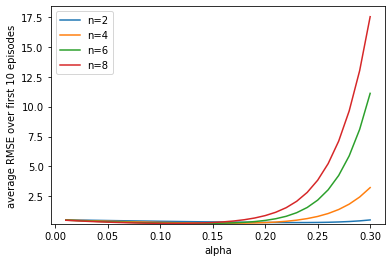

In [117]:
# Reproduce Figure 7.2, off-line update, but only for even n's and no upward limit
alpha_list = [a/100. for a in range(1, 31)] # just from 0.01 to 0.3
for n in [2, 4, 6, 8]:
    rmse = []
    for alpha in alpha_list:
        tmp_rmse = 0.
        for e in range(100):
            walks = experiments[e]  # the set of 10 walks
            V = off_line_n_step_update(walks, n=n, alpha=alpha)
            tmp_rmse += math.sqrt(sum([(vi - true_vi)**2 for vi, true_vi in zip(V, true_V)]) / (len(V) - 2)) # exclude terminal states
        rmse.append(tmp_rmse / 100.)  # average over the 100 experiments
    plt.plot(alpha_list, rmse, label=f'n={n}')
plt.xlabel('alpha')
plt.ylabel('average RMSE over first 10 episodes')
plt.ylim(bottom=0.2)
plt.legend()
plt.show()

Hmmm, so they're also misbehaving, but were eclipsed by the much larger RMS errors for odd $n$'s.

Even more, if we allow $\alpha$ to go all the way to $1$ as for the on-line update graph, we get way worse performance:

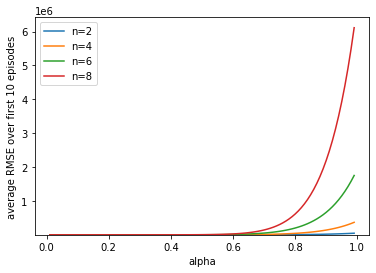

In [118]:
# Reproduce Figure 7.2, off-line update, but only for even n's and no upward limit
alpha_list = [a/100. for a in range(1, 100)] # from 0.01 to 0.99
for n in [2, 4, 6, 8]:
    rmse = []
    for alpha in alpha_list:
        tmp_rmse = 0.
        for e in range(100):
            walks = experiments[e]  # the set of 10 walks
            V = off_line_n_step_update(walks, n=n, alpha=alpha)
            tmp_rmse += math.sqrt(sum([(vi - true_vi)**2 for vi, true_vi in zip(V, true_V)]) / (len(V) - 2)) # exclude terminal states
        rmse.append(tmp_rmse / 100.)  # average over the 100 experiments
    plt.plot(alpha_list, rmse, label=f'n={n}')
plt.xlabel('alpha')
plt.ylabel('average RMSE over first 10 episodes')
plt.ylim(bottom=0.2)
plt.legend()
plt.show()

So for $\alpha$ > 0.5, RMSE quickly goes into the millions.

By now we're confident that the problem is much worse (and different) than initially thought, __regardless of $n$ being even or odd. It might indicate a problem in the algorithm. And indeed that's what is happening.__ If we go back to page 166, it says that "the increments are accumulated on the side" and applied at the end of the episode, which sounds right. The formula next to it is also given. But at a closer inspection, suppose you begin with $V(s) = 0$ for some state $s$ and we take 10 n-step walks from it, of which 8 finish in the left terminal and 2 in the right terminal. So the accumulated TD error is $\sum \Delta V(s) = \alpha \left[ 8 (-1 - 0) + 2 (1 - 0) \right] = 6 \alpha$. At the end of the episode we apply the update and $V(s)$ becomes $V(s) + 6 \alpha$. But if $\alpha$ is large enough, in this case any value above $\frac{1}{6} \approx 0.17$, then $V(s) \gt 1$, i.e. outside any reasonable expectation that $-1 \le V(s) \le 1$. Once the estimates escape the interval $[-1, 1]$, the self-reinforcing effect described above is taking over and the estimates get very wrong as we have seen, especially for larger $\alpha$.

What is the fix?

Well, rather simple actually, instead of adding the __sum__ of the accumulated increments $\Delta V(s)$ to $V(s)$, we add their __mean__. This guarantees the value estimates never go below / above the minimum / maximum target values, and RMSE now behave nicely for any $\alpha \in (0, 1)$.

In [120]:
# Implement the corrected off-line n-step TD update
# from a list of walks
def off_line_n_step_update(walks, n, alpha, nb_states=19):
    # init V=0, plus -1, 1 on the sides
    V = [-1.] + [0.] * nb_states + [1.]
    for walk in walks:
        # DeltaV to be used for the update at the end of the episode
        DV = {}
        DV_k = {}  # counter

        for pos in range(len(walk)-1):
            start_state = walk[pos]
            end_state = walk[min(pos + n, len(walk)-1)]

            if start_state not in DV:
                DV[start_state] = 0.
                DV_k[start_state] = 0
            # accumulate DeltaV "on the side"
            DV[start_state] += V[end_state] - V[start_state]
            DV_k[start_state] += 1

        new_V = V.copy()
        # update V for all visited states
        for s in range(1, nb_states+1):
            if s in DV:
                # original formula page 166
                # new_V[s] = new_V[s] + alpha * DV[s]
                # simply divide the increments by their count
                new_V[s] = new_V[s] + alpha * DV[s] / DV_k[s]
        V = new_V
    return V

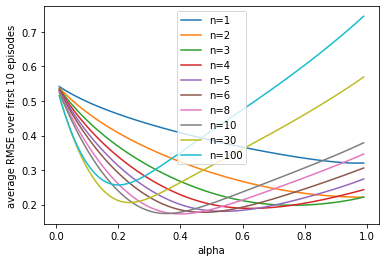

In [124]:
# off-line n-step TD update, this time with average update
alpha_list = [a/100. for a in range(1, 100)] # from 0.01 to 0.99
for n in [1, 2, 3, 4, 5, 6, 8, 10, 30, 100]:
    rmse = []
    for alpha in alpha_list:
        tmp_rmse = 0.
        for e in range(100):
            walks = experiments[e]  # the set of 10 walks
            V = off_line_n_step_update(walks, n=n, alpha=alpha)
            tmp_rmse += math.sqrt(sum([(vi - true_vi)**2 for vi, true_vi in zip(V, true_V)]) / (len(V) - 2)) # exclude terminal states
        rmse.append(tmp_rmse / 100.)  # average over the 100 experiments
    plt.plot(alpha_list, rmse, label=f'n={n}')
plt.xlabel('alpha')
plt.ylabel('average RMSE over first 10 episodes')
plt.legend()
plt.show()

All looks good now! No more odd vs. even $n$'s difference; they seem to form a nice regular pattern. And more importantly, no huge errors for larger $\alpha$. The results are similar (or slightly better) to on-line n-step TD. And actually that's what one would expect, more stable estimates from accumulating (and aggregating) multiple noisy signals.

### Exercise 7.4

(...) What is the equation relating the parameter $\lambda$ and the half-life ${\tau}_{\lambda}$, the time by which the weighting sequence will have fallen to half of its initial value?

The largest weight is for the 1-step return, i.e. $1 - \lambda$. In general, the weight for an n-step return is $(1 - \lambda) \lambda^{n-1}$. Now we require that for some time step $\tau_{\lambda}$, its corresponding weight is half of the initial value, i.e. 

$$
(1 - \lambda) \lambda^{\tau_{\lambda} - 1} = \dfrac{1}{2} (1 - \lambda) \iff \tau_{\lambda} - 1 = \dfrac {\ln \frac{1}{2}} {\ln \lambda} \iff \boxed { \tau_{\lambda} = 1 - \dfrac {\ln 2} {\ln \lambda} } \qquad \square
$$

### Exercise 7.5

Although TD($\lambda$) only approximates the $\lambda$-return algorithm when done on-line, perhaps there is a slightly different TD method that would maintain the equivalence even in the on-line case. One idea is to define the TD error instead as $\delta_t = r_{t+1} + \gamma V_t(s_{t+1}) - V_{t-1}(s_t)$ and the n-step return as $R_t^{(n)} = r_{t+1} + ... + \gamma^{n-1} r_{t+n} + \gamma^n V_{t+n-1} (s_{t+n})$. Show that in this case the modified TD($\lambda$) algorithm would then achieve exactly $\Delta V_t(s_t) = \alpha \left[ R_t^{\lambda} - V_{t-1}(s_t) \right]$, even in the case of on-line updating with large $\alpha$. In what ways might this modified TD($\lambda$) be better or worse than the conventional one described in the text? Describe an experiment to assess the relative merits of the two algorithms.

__Answer__: The problem of the on-line TD($\lambda$) is that $V$ changes at every step, so the equivalence with the $\lambda$-return algorithm can't be proved other than approximately (see the proof in Section 7.4). Let's use the new definitions from this exercise to attempt a similar proof.

We start by looking on the right side of equation (7.8). An individual update of the modified $\lambda$-return becomes:

$$
\begin{align*}
    \dfrac {1} {\alpha} DV_t^{\lambda} (s_t) & = R_t^{\lambda} - V_{t-1}(s_t) \\
    & = -V_{t-1}(s_t) && + ( 1 - \lambda) \lambda^0 [r_{t+1} + \gamma V_t(s_{t+1})] \\
    & && + ( 1 - \lambda) \lambda^1 [r_{t+1} + \gamma r_{t+2} + \gamma^2 V_{t+1}(s_{t+2})] \\
    & && + ( 1 - \lambda) \lambda^2 [r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \gamma^3 V_{t+2}(s_{t+3})] \\
    & && + \qquad \qquad \qquad \vdots \qquad \qquad \vdots \qquad \qquad \vdots \qquad \qquad \ddots \\
    & && \\
    & && \text {and after same reorganizing terms by column, as in Section 7.4}
    & && \\
    & = -V_{t-1}(s_t) \\
    & \quad && + (\gamma \lambda)^0 [r_{t+1} + \gamma V_t(s_{t+1}) - \gamma \lambda V_t(s_{t+1})] \\
    & \quad && + (\gamma \lambda)^1 [r_{t+2} + \gamma V_{t+1}(s_{t+2}) - \gamma \lambda V_{t+1}(s_{t+2})] \\
    & \quad && + (\gamma \lambda)^2 [r_{t+3} + \gamma V_{t+2}(s_{t+3}) - \gamma \lambda V_{t+2}(s_{t+3})] \\
    & && \qquad \vdots \\
    \\
    & = && \quad (\gamma \lambda)^0 [r_{t+1} + \gamma V_t(s_{t+1}) - V_{t-1}(s_{t})] \\
    & && + (\gamma \lambda)^1 [r_{t+2} + \gamma V_{t+1}(s_{t+2}) - V_{t}(s_{t+1})] \\
    & && + (\gamma \lambda)^2 [r_{t+3} + \gamma V_{t+2}(s_{t+3}) - V_{t+1}(s_{t+2})] \\
    & && \qquad \vdots \\
    \\
    & = \sum_{k=t}^{\infty} (\gamma \lambda)^{k-t} \delta_k \\
    & = \sum_{k=t}^{T-1} (\gamma \lambda)^{k-t} \delta_k \\
\end{align*}
$$

Note that this time the previous equality is __exact__, due to the modified definition of $\delta_t$ and the fact that $V$ doesn't need to remain fixed as before. For every term in the sum, we only need the current and previous values of $V$ at any time step.

The rest of the proof follows exactly the same as in Section 7.4, by noticing that:

$$
    \sum_{t=0}^{T-1} \Delta V_t^{\lambda} (s_t) \mathcal{I}_{ss_t} = \sum_{t=0}^{T-1} \alpha \mathcal{I}_{ss_t} \sum_{k=t}^{T-1} (\gamma \lambda)^{k-t} \delta_k \text {, which is the same as (7.9)}
$$

So this proves that the off-line $\lambda$-return algorithm with the redefined n-step return $R_t^{(n)}$ is exactly equivalent to the on-line TD($\lambda$) with the redefined increment $\delta_t$.

It's not immediately clear if this modified on-line TD($\lambda$) algorithm is better than the conventional one, because the increment is now relative to a previous estimation of $V(s_t)$, i.e. $V_{t-1}(s_t)$, not the latest available $V_t(s_t)$. An experiment could be run on the 19-states random walk task and compare RMS error from true values after some number of episodes. In particular by using a large value of $\alpha$, the difference should be clear at the same level of $\lambda$.